# Using machine learning XGboost classifier to look for different pattern between Ketamin and Midazolam groups

In [187]:
# import relevant packages
import glob
import numpy as np
import scipy
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## No apperant contribution to before/after treatment in general. 
- Lets look at group differences in ROIs $\rightarrow$
    * Amygdala
    * vmPFC
    * Hippocampus
    * Striatum
- We compare pattern of ROI activation in the trauma > relax contrast on the 2nd day

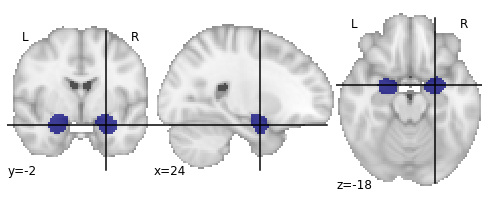

In [193]:
## Amygdala as mask
mask_file = '/media/Data/work/KPE_ROI/amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=20", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)


masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=2, standardize=False, detrend=False, verbose=5)

In [194]:
# compare between groups
import pandas as pd
medication_cond = pd.read_csv('/home/or/kpe_task_analysis/task_based_analysis/kpe_sub_condition.csv')

ketamine_list = list(medication_cond['scr_id'][medication_cond['med_cond']==1])
ket_list = []
for subject in ketamine_list:
    
    sub = subject.split('KPE')[1]
    ket_list.append(sub)


midazolam_list = list(medication_cond['scr_id'][medication_cond['med_cond']==0])
mid_list = []
for subject in midazolam_list:
    
    sub = subject.split('KPE')[1]
    mid_list.append(sub)
#mid_list.remove('1480')

In [195]:
ket_func = ['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz'% (sub) for sub in ket_list]
mid_func = ['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz' % (sub) for sub in mid_list]

In [124]:
#mid_list.remove('1480')

In [196]:
ketamine = []
for func in ket_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    ketamine.append(beta)

midazolam = []
for func in mid_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    midazolam.append(beta)

ketArr = np.array(ketamine)
ketArr_reshape= np.array(ketArr).reshape(ketArr.shape[0], ketArr.shape[2])
ketArr_reshape.shape


midArr = np.array(midazolam)
midArr_reshape= np.array(midArr).reshape(midArr.shape[0], midArr.shape[2])
midArr_reshape.shape


## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * ketArr.shape[0]
label2 = [0] * midArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

X = np.concatenate([ketArr, midArr])
X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_008/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1223/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mas

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1263/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1351/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMas

(21, 932)

In [199]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
model = XGBClassifier(n_jobs=8, 
                     verbose = 9, random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=5, shuffle=True) # running for each subject


## Use shuffle split to randomize and run the XGboost N times
- This will create a distribution of estimation level 
- We can then better estimate how really its more accurate than chance


In [200]:
n_iter = 1000
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

 Running 362 iteration
 Running 363 iteration
 Running 364 iteration
 Running 365 iteration
 Running 366 iteration
 Running 367 iteration
 Running 368 iteration
 Running 369 iteration
 Running 370 iteration
 Running 371 iteration
 Running 372 iteration
 Running 373 iteration
 Running 374 iteration
 Running 375 iteration
 Running 376 iteration
 Running 377 iteration
 Running 378 iteration
 Running 379 iteration
 Running 380 iteration
 Running 381 iteration
 Running 382 iteration
 Running 383 iteration
 Running 384 iteration
 Running 385 iteration
 Running 386 iteration
 Running 387 iteration
 Running 388 iteration
 Running 389 iteration
 Running 390 iteration
 Running 391 iteration
 Running 392 iteration
 Running 393 iteration
 Running 394 iteration
 Running 395 iteration
 Running 396 iteration
 Running 397 iteration
 Running 398 iteration
 Running 399 iteration
 Running 400 iteration
 Running 401 iteration
 Running 402 iteration
 Running 403 iteration
 Running 404 iteration
 Running 40

 Running 719 iteration
 Running 720 iteration
 Running 721 iteration
 Running 722 iteration
 Running 723 iteration
 Running 724 iteration
 Running 725 iteration
 Running 726 iteration
 Running 727 iteration
 Running 728 iteration
 Running 729 iteration
 Running 730 iteration
 Running 731 iteration
 Running 732 iteration
 Running 733 iteration
 Running 734 iteration
 Running 735 iteration
 Running 736 iteration
 Running 737 iteration
 Running 738 iteration
 Running 739 iteration
 Running 740 iteration
 Running 741 iteration
 Running 742 iteration
 Running 743 iteration
 Running 744 iteration
 Running 745 iteration
 Running 746 iteration
 Running 747 iteration
 Running 748 iteration
 Running 749 iteration
 Running 750 iteration
 Running 751 iteration
 Running 752 iteration
 Running 753 iteration
 Running 754 iteration
 Running 755 iteration
 Running 756 iteration
 Running 757 iteration
 Running 758 iteration
 Running 759 iteration
 Running 760 iteration
 Running 761 iteration
 Running 76

### Plotting area under ROC curve ditribution and printing average and standard deviation of the distribution

Area under curve: 0.73 (+/- 0.19)
90% CI is [0.55791667 0.86666667]


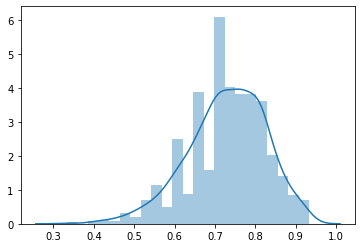

In [201]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'90% CI is {np.quantile(rand_score, [0.05, 0.95])}')
sns.distplot(rand_score)

## Now we will do similar thing - just shuffling the condition label (Y) so we basically randomizing the lables
This should generate a chance level prediction

In [449]:
## Lets do permutation tests - shuffling the condition label
import random
condPerm = np.array(condition_label)
permScor = []
#cv = KFold(n_splits=10)
for i in range(n_iter):
    print (f'Running the {i+1} iteration')
    random.shuffle(condPerm)
    print(condPerm)
    
    mean_scores = []
    cv_scores = cross_val_score(model,
                            X,
                            y=condPerm,
                            cv=cv,
                            groups=condPerm,
                            scoring="f1",#"roc_auc",
                            n_jobs=11, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(cv_scores.mean())
    permScor.append(mean_scores)

Running the 1 iteration
[1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0]
Running the 2 iteration
[0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0]
Running the 3 iteration
[1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0]
Running the 4 iteration
[1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 0]
Running the 5 iteration
[0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1]
Running the 6 iteration
[1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1]
Running the 7 iteration
[0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1]
Running the 8 iteration
[1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0]
Running the 9 iteration
[1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0]
Running the 10 iteration
[1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1]
Running the 11 iteration
[1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0]
Running the 12 iteration
[0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1]
Running the 13 iteration
[1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0]
Running the 14 iteration
[1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1]
Running the 15 iteration
[0 1 1 1 0 1 1 0 0

Running the 120 iteration
[1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0]
Running the 121 iteration
[1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0]
Running the 122 iteration
[1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0]
Running the 123 iteration
[0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1]
Running the 124 iteration
[0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1]
Running the 125 iteration
[1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1]
Running the 126 iteration
[1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1]
Running the 127 iteration
[0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0]
Running the 128 iteration
[0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0]
Running the 129 iteration
[0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1]
Running the 130 iteration
[1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1]
Running the 131 iteration
[1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0]
Running the 132 iteration
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0]
Running the 133 iteration
[0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0]
Running the 134 iter

Running the 238 iteration
[1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1]
Running the 239 iteration
[0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1]
Running the 240 iteration
[0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1]
Running the 241 iteration
[0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1]
Running the 242 iteration
[0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1]
Running the 243 iteration
[0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1]
Running the 244 iteration
[1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0]
Running the 245 iteration
[1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1]
Running the 246 iteration
[1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1]
Running the 247 iteration
[1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1]
Running the 248 iteration
[1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1]
Running the 249 iteration
[0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0]
Running the 250 iteration
[1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1]
Running the 251 iteration
[0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0]
Running the 252 iter

Running the 356 iteration
[1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0]
Running the 357 iteration
[0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1]
Running the 358 iteration
[0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1]
Running the 359 iteration
[1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1]
Running the 360 iteration
[0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1]
Running the 361 iteration
[1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1]
Running the 362 iteration
[0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0]
Running the 363 iteration
[1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0]
Running the 364 iteration
[1 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1]
Running the 365 iteration
[1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1]
Running the 366 iteration
[1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1]
Running the 367 iteration
[0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1]
Running the 368 iteration
[1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1]
Running the 369 iteration
[1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0]
Running the 370 iter

Running the 474 iteration
[0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1]
Running the 475 iteration
[0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0]
Running the 476 iteration
[1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1]
Running the 477 iteration
[1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1]
Running the 478 iteration
[0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0]
Running the 479 iteration
[1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0]
Running the 480 iteration
[1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0]
Running the 481 iteration
[1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0]
Running the 482 iteration
[1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0]
Running the 483 iteration
[1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0]
Running the 484 iteration
[1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0]
Running the 485 iteration
[1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0]
Running the 486 iteration
[0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1]
Running the 487 iteration
[0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0]
Running the 488 iter

Running the 592 iteration
[1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0]
Running the 593 iteration
[0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0]
Running the 594 iteration
[1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0]
Running the 595 iteration
[0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1]
Running the 596 iteration
[1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0]
Running the 597 iteration
[0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0]
Running the 598 iteration
[1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0]
Running the 599 iteration
[1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1]
Running the 600 iteration
[0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0]
Running the 601 iteration
[1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1]
Running the 602 iteration
[1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0]
Running the 603 iteration
[1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0]
Running the 604 iteration
[0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1]
Running the 605 iteration
[0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0]
Running the 606 iter

Running the 710 iteration
[0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1]
Running the 711 iteration
[1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1]
Running the 712 iteration
[0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1]
Running the 713 iteration
[0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1]
Running the 714 iteration
[1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1]
Running the 715 iteration
[0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0]
Running the 716 iteration
[0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1]
Running the 717 iteration
[1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1]
Running the 718 iteration
[1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0]
Running the 719 iteration
[1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0]
Running the 720 iteration
[0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0]
Running the 721 iteration
[1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1]
Running the 722 iteration
[1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0]
Running the 723 iteration
[1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1]
Running the 724 iter

Running the 828 iteration
[0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1]
Running the 829 iteration
[1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1]
Running the 830 iteration
[0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0]
Running the 831 iteration
[1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1]
Running the 832 iteration
[1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0]
Running the 833 iteration
[1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0]
Running the 834 iteration
[0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1]
Running the 835 iteration
[0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1]
Running the 836 iteration
[0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0]
Running the 837 iteration
[0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1]
Running the 838 iteration
[1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0]
Running the 839 iteration
[1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1]
Running the 840 iteration
[0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0]
Running the 841 iteration
[1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1]
Running the 842 iter

Running the 946 iteration
[1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1]
Running the 947 iteration
[1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1]
Running the 948 iteration
[1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0]
Running the 949 iteration
[1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0]
Running the 950 iteration
[0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1]
Running the 951 iteration
[1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0]
Running the 952 iteration
[1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0]
Running the 953 iteration
[0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1]
Running the 954 iteration
[0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0]
Running the 955 iteration
[0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0]
Running the 956 iteration
[1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1]
Running the 957 iteration
[1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0]
Running the 958 iteration
[1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1]
Running the 959 iteration
[1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0]
Running the 960 iter

 Mean of permutation score is 0.4956195238095238


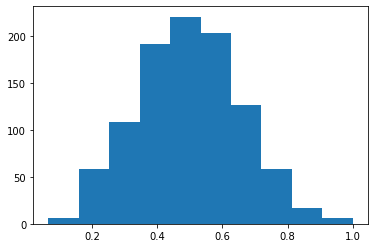

In [450]:
# now lets see the mean score
score = np.array(permScor)

#import matplotlib.pyplot as plt
plt.hist(score)
print(f' Mean of permutation score is {np.mean(score)}')

 Chances of mean permutation score to be random is 0.088


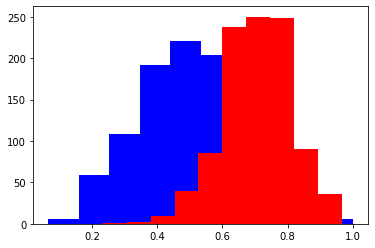

In [451]:
#plot permutation histogram and real one
plt.hist(score, color="blue")
plt.hist(rand_score, color="red")
# chances of getting our score
print(f' Chances of mean permutation score to be random is {len(score[score>=np.mean(rand_score)])/len(score)}')

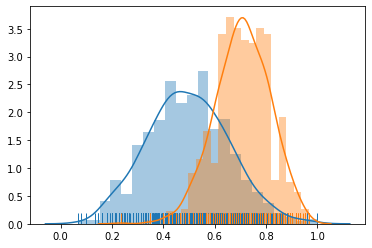

In [452]:

sns.distplot(score, hist=True, rug=True)
sns.distplot(rand_score, hist=True, rug=True)

(array([0.001, 0.002, 0.01 , 0.039, 0.086, 0.238, 0.25 , 0.248, 0.09 ,
        0.036]),
 array([0.23333333, 0.30666667, 0.38      , 0.45333333, 0.52666667,
        0.6       , 0.67333333, 0.74666667, 0.82      , 0.89333333,
        0.96666667]),
 <a list of 10 Patch objects>)

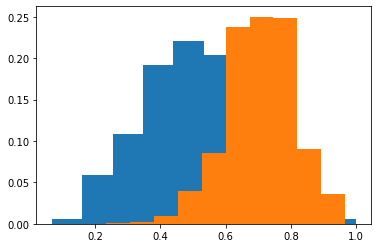

In [453]:
weights = np.ones_like(score) / len(score)
weights_real = np.ones_like(rand_score) / len(rand_score)
plt.hist(score, weights=weights)
plt.hist(rand_score, weights=weights_real)

## Lets plot each group's array to see the pattern of activation

In [254]:
## check maximum and minimum values
np.min(midArr_reshape)

-225.35812

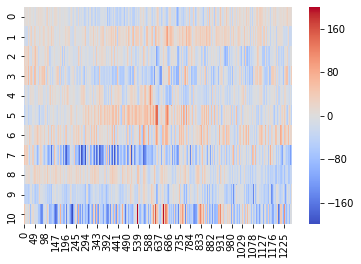

In [264]:

#plt.figure(figsize=(30,10))
sns.heatmap(ketArr_reshape, cmap="coolwarm", vmax=200, vmin = -200)#,linewidth=0.1)
plt.show()
#plt.imshow(ketArr_reshape, axis=0), cmap = "hot")

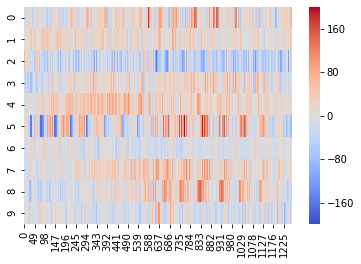

In [265]:
#plt.figure(figsize=(30,10))
sns.heatmap(midArr_reshape, cmap="coolwarm",vmax=200, vmin = -200)#,linewidth=0.1)
plt.show()

### plot average pattern for each group
- Ketamin


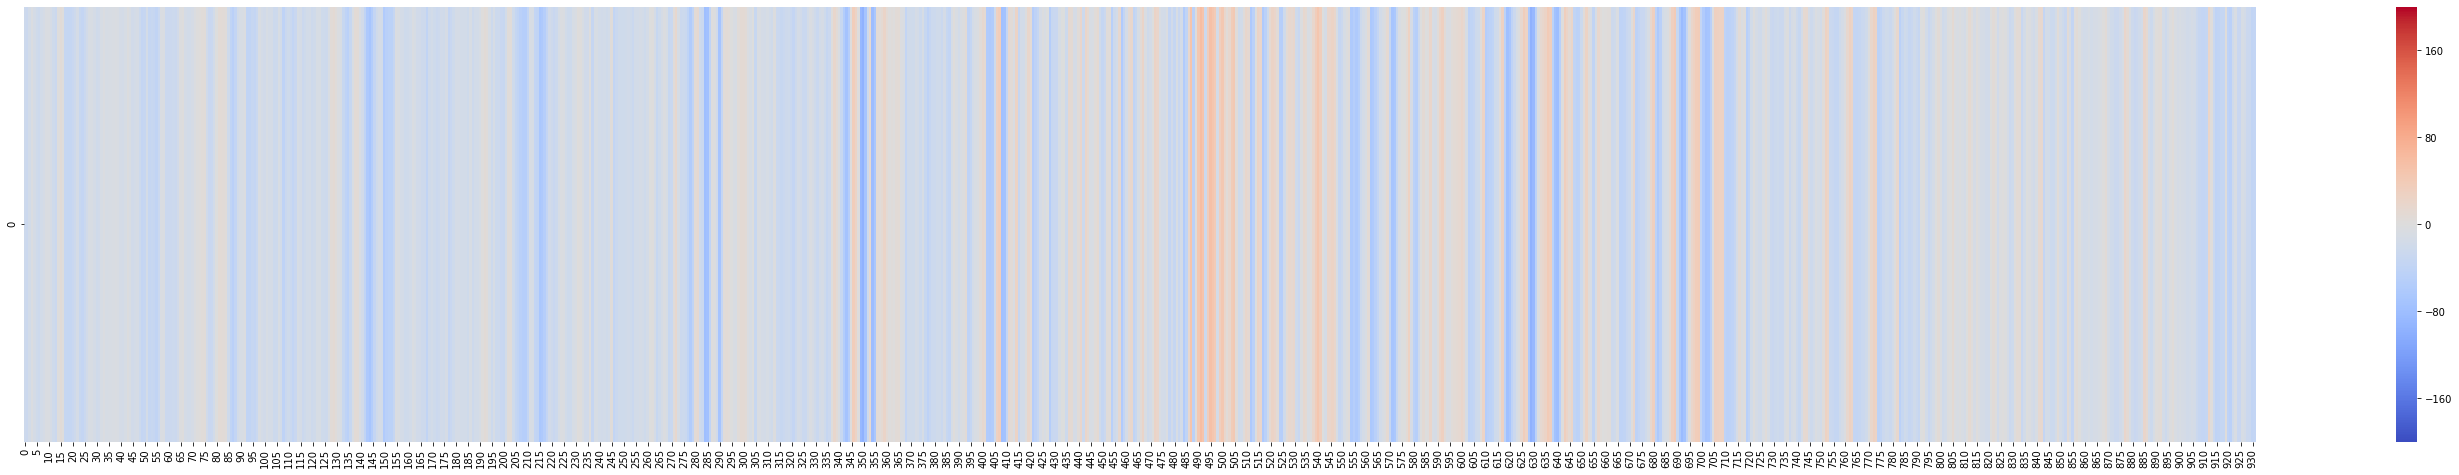

In [205]:
plt.figure(figsize=(50,8))
sns.heatmap([np.mean(ketArr_reshape, axis=0)],cmap="coolwarm",vmax=200, vmin = -200 )

- Midazolam

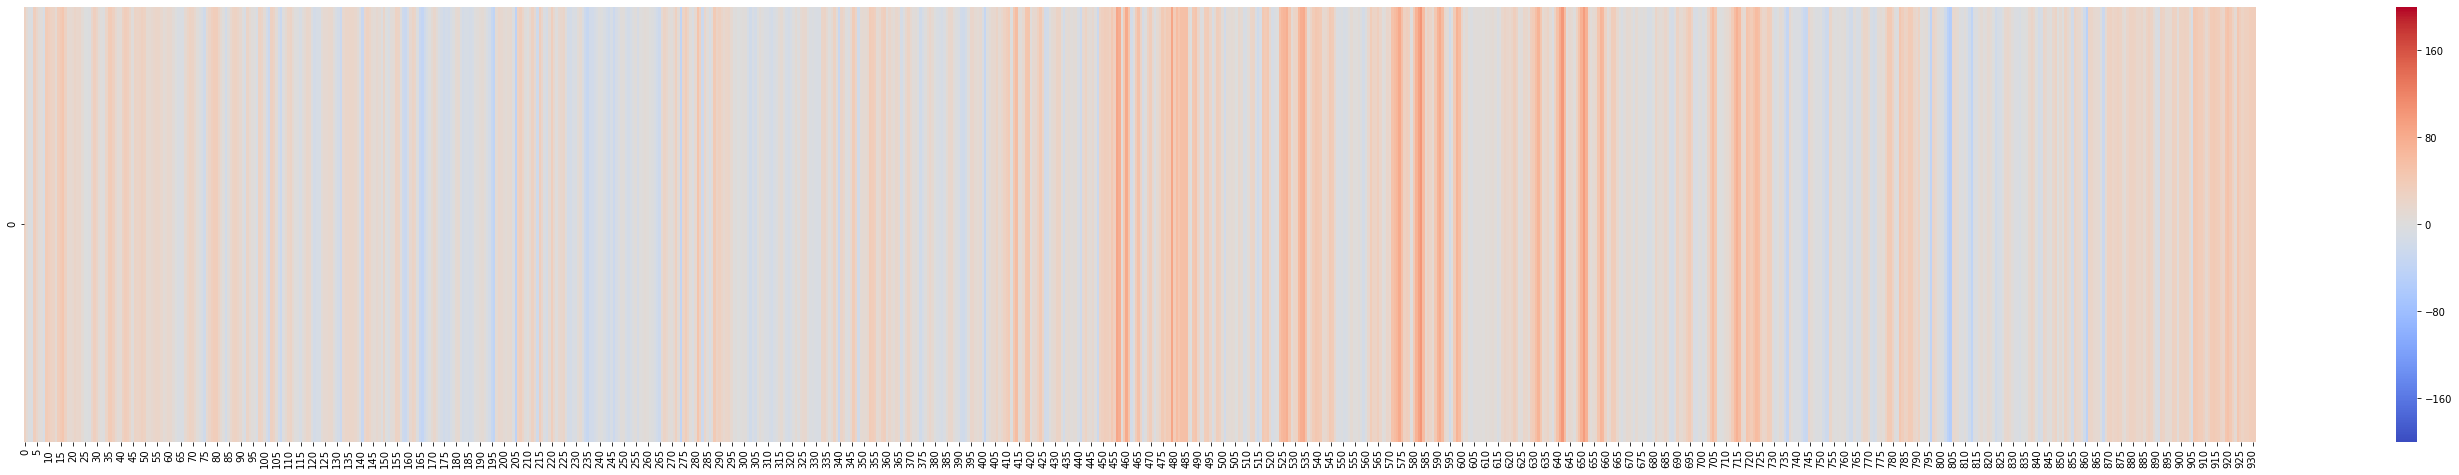

In [206]:
plt.figure(figsize=(50,8))
sns.heatmap([np.mean(midArr_reshape, axis=0)],cmap="coolwarm",vmax=200, vmin = -200 )

In [207]:
deltaKetminusMid = np.mean(ketArr_reshape, axis=0) - np.mean(midArr_reshape, axis=0)
np.mean(deltaKetminusMid)

-27.613214

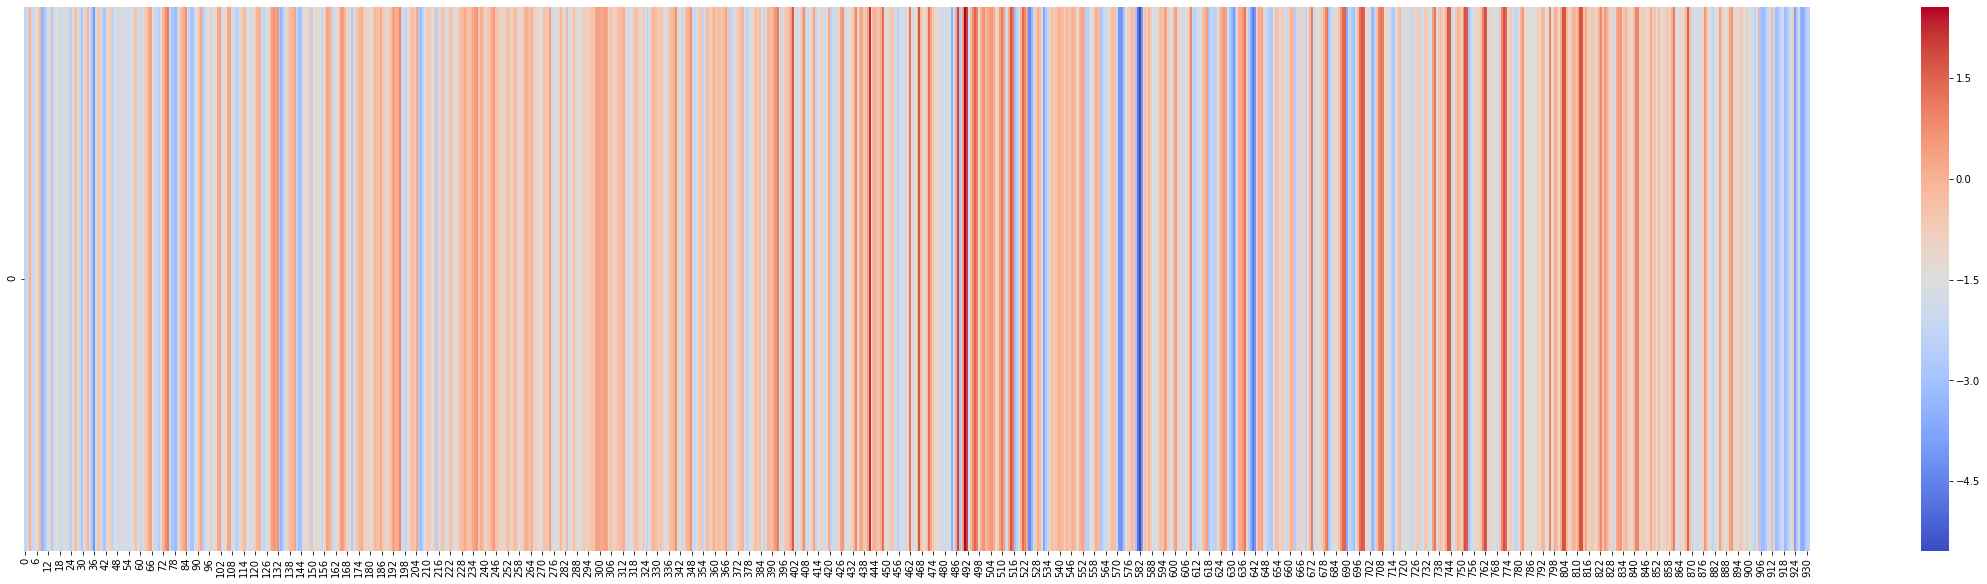

In [208]:
# t test
tTestArr = scipy.stats.ttest_ind(ketArr_reshape, midArr_reshape,  equal_var=True, nan_policy='propagate')
plt.figure(figsize=(40,10))
sns.heatmap([tTestArr[0]], cmap="coolwarm")

## show the t-test difference between the groups

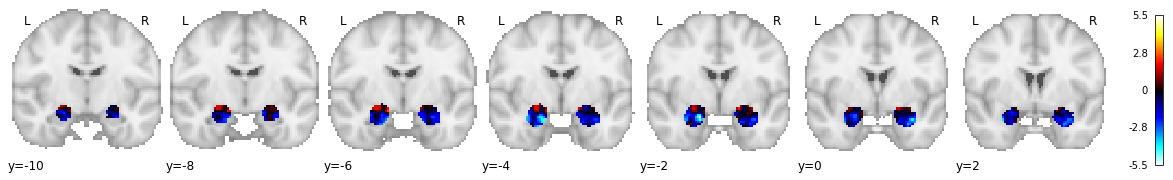

In [210]:
# turn back to brain?
img = masker.inverse_transform(tTestArr[0])
nilearn.plotting.plot_stat_map(img, display_mode='y', threshold=0)

## Plot amygdala pattern in each group

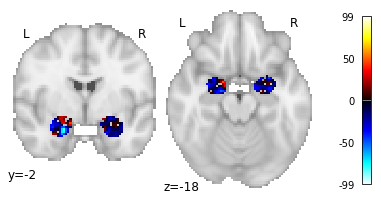

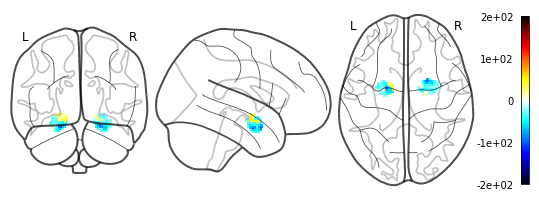

In [222]:
img_ket = masker.inverse_transform(np.mean(ketArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_ket, threshold=1.5, display_mode='yz', draw_cross=False, 
                           cut_coords=[-2,-18],colorbar=True, vmax=99)  
nilearn.plotting.plot_glass_brain(img_ket, vmin = -200, vmax = 200, colorbar=True, plot_abs=False)

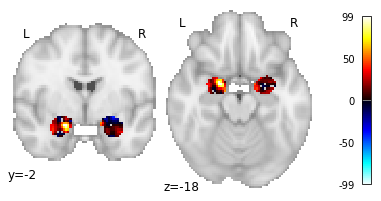

In [223]:
img_mid = masker.inverse_transform(np.mean(midArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_mid, threshold=1.5, display_mode='yz', draw_cross=False, 
                           cut_coords=[-2,-18],colorbar=True, vmax=99)


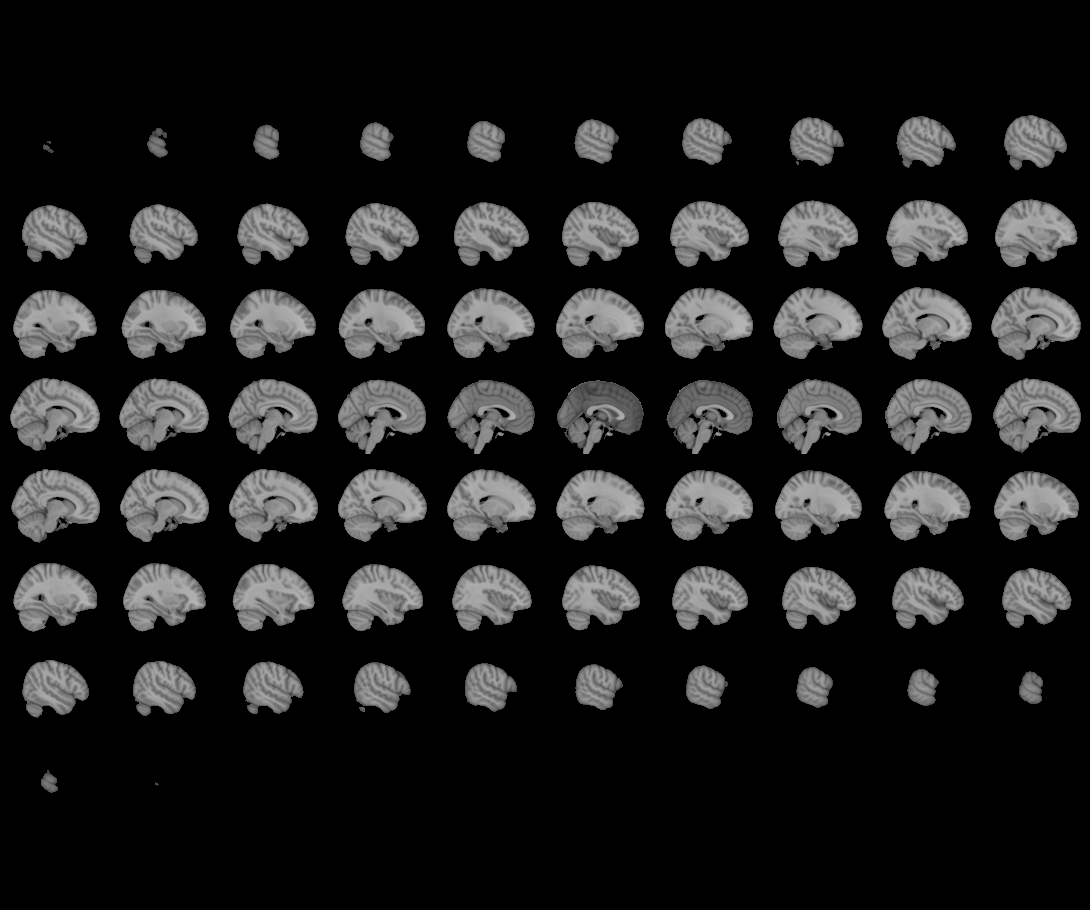
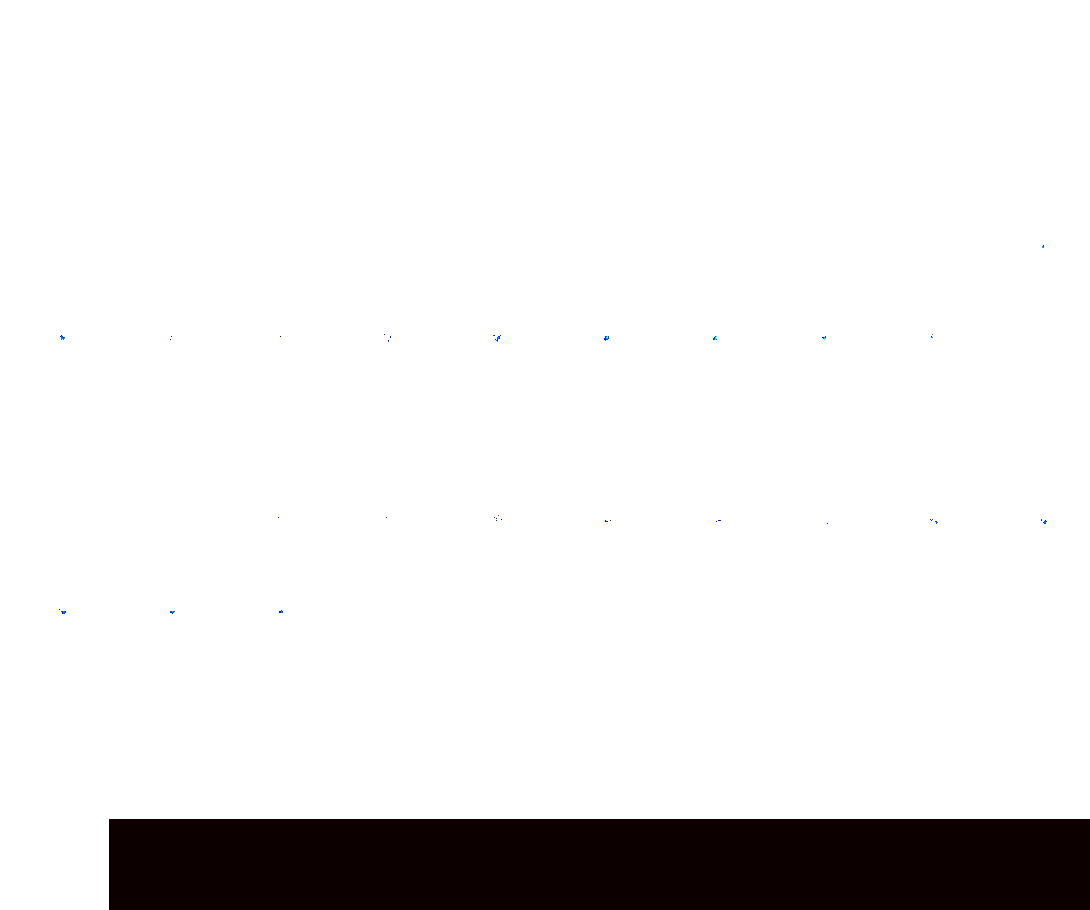

In [40]:
# another trial of interactive plottive  
view = nilearn.plotting.view_img(img, threshold=2, title="Ketamine - Midazolam Amygdala")
view

## Now we do similar thing but with vmPFC 
As it might be involved in regular (no reconsolidated) extinction learning

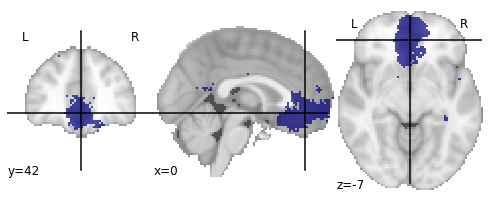

In [224]:
mask_file = '/media/Data/work/RCF_or/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=4", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=4, standardize=False, detrend=False, verbose=5)

In [225]:
ketamine = []
for func in ket_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    ketamine.append(beta)

midazolam = []
for func in mid_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    midazolam.append(beta)

ketArr = np.array(ketamine)
ketArr_reshape= np.array(ketArr).reshape(ketArr.shape[0], ketArr.shape[2])
ketArr_reshape.shape


midArr = np.array(midazolam)
midArr_reshape= np.array(midArr).reshape(midArr.shape[0], midArr.shape[2])
midArr_reshape.shape


## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * ketArr.shape[0]
label2 = [0] * midArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

X = np.concatenate([ketArr, midArr])
X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_008/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1223/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mas

[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1263/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/wo

(21, 3846)

In [226]:
n_iter = 1000
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

 Running 362 iteration
 Running 363 iteration
 Running 364 iteration
 Running 365 iteration
 Running 366 iteration
 Running 367 iteration
 Running 368 iteration
 Running 369 iteration
 Running 370 iteration
 Running 371 iteration
 Running 372 iteration
 Running 373 iteration
 Running 374 iteration
 Running 375 iteration
 Running 376 iteration
 Running 377 iteration
 Running 378 iteration
 Running 379 iteration
 Running 380 iteration
 Running 381 iteration
 Running 382 iteration
 Running 383 iteration
 Running 384 iteration
 Running 385 iteration
 Running 386 iteration
 Running 387 iteration
 Running 388 iteration
 Running 389 iteration
 Running 390 iteration
 Running 391 iteration
 Running 392 iteration
 Running 393 iteration
 Running 394 iteration
 Running 395 iteration
 Running 396 iteration
 Running 397 iteration
 Running 398 iteration
 Running 399 iteration
 Running 400 iteration
 Running 401 iteration
 Running 402 iteration
 Running 403 iteration
 Running 404 iteration
 Running 40

 Running 719 iteration
 Running 720 iteration
 Running 721 iteration
 Running 722 iteration
 Running 723 iteration
 Running 724 iteration
 Running 725 iteration
 Running 726 iteration
 Running 727 iteration
 Running 728 iteration
 Running 729 iteration
 Running 730 iteration
 Running 731 iteration
 Running 732 iteration
 Running 733 iteration
 Running 734 iteration
 Running 735 iteration
 Running 736 iteration
 Running 737 iteration
 Running 738 iteration
 Running 739 iteration
 Running 740 iteration
 Running 741 iteration
 Running 742 iteration
 Running 743 iteration
 Running 744 iteration
 Running 745 iteration
 Running 746 iteration
 Running 747 iteration
 Running 748 iteration
 Running 749 iteration
 Running 750 iteration
 Running 751 iteration
 Running 752 iteration
 Running 753 iteration
 Running 754 iteration
 Running 755 iteration
 Running 756 iteration
 Running 757 iteration
 Running 758 iteration
 Running 759 iteration
 Running 760 iteration
 Running 761 iteration
 Running 76

Area under curve: 0.70 (+/- 0.22)
90% CI is [0.51666667 0.86666667]


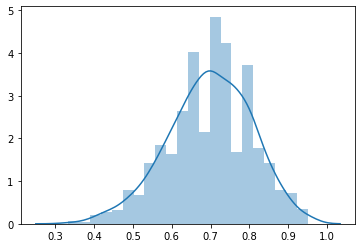

In [227]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'90% CI is {np.quantile(rand_score, [0.05, 0.95])}')
sns.distplot(rand_score)

## Same method does somehow discriminate between midazolam and ketamine group


### Let's look at the pattern of activation

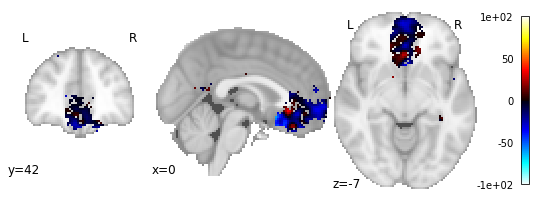

In [242]:
img_ket = masker.inverse_transform(np.mean(ketArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_ket, threshold=1, display_mode='ortho', draw_cross=False, 
                          cut_coords=[0,42,-7], colorbar=True, vmax=100)

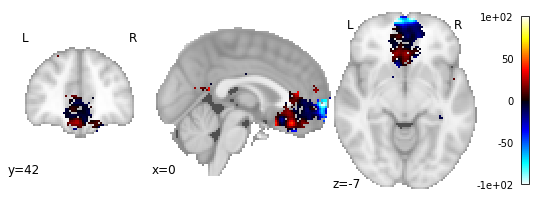

In [243]:
img_mid = masker.inverse_transform(np.mean(midArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_mid, threshold=1, display_mode='ortho', draw_cross=False, 
                          cut_coords=[0,42,-7], colorbar=True, vmax=100)

Seems like midazolam presents higher activation in some regions of the vmPFC.

This supports the idea of ketamine as promoting reconsolidation, while midazolam patients recovery is more associated with the typical, yet transient extinction.

## Lets look at the hippocampus

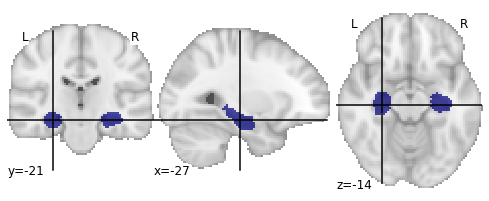

In [277]:
mask_file = '/media/Data/work/KPE_ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=13", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=4, standardize=False, detrend=False, verbose=5)

In [278]:
## run all analysis in one cell
ketamine = []
for func in ket_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    ketamine.append(beta)
midazolam = []
for func in mid_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    midazolam.append(beta)
ketArr = np.array(ketamine)
ketArr_reshape= np.array(ketArr).reshape(ketArr.shape[0], ketArr.shape[2])
ketArr_reshape.shape
midArr = np.array(midazolam)
midArr_reshape= np.array(midArr).reshape(midArr.shape[0], midArr.shape[2])
midArr_reshape.shape


Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_008/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1223/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mas

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1263/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1351/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMas

(10, 1265)

In [279]:
## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * ketArr.shape[0]
label2 = [0] * midArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

X = np.concatenate([ketArr, midArr])
X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

n_iter = 1000
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

 Running 362 iteration
 Running 363 iteration
 Running 364 iteration
 Running 365 iteration
 Running 366 iteration
 Running 367 iteration
 Running 368 iteration
 Running 369 iteration
 Running 370 iteration
 Running 371 iteration
 Running 372 iteration
 Running 373 iteration
 Running 374 iteration
 Running 375 iteration
 Running 376 iteration
 Running 377 iteration
 Running 378 iteration
 Running 379 iteration
 Running 380 iteration
 Running 381 iteration
 Running 382 iteration
 Running 383 iteration
 Running 384 iteration
 Running 385 iteration
 Running 386 iteration
 Running 387 iteration
 Running 388 iteration
 Running 389 iteration
 Running 390 iteration
 Running 391 iteration
 Running 392 iteration
 Running 393 iteration
 Running 394 iteration
 Running 395 iteration
 Running 396 iteration
 Running 397 iteration
 Running 398 iteration
 Running 399 iteration
 Running 400 iteration
 Running 401 iteration
 Running 402 iteration
 Running 403 iteration
 Running 404 iteration
 Running 40

 Running 719 iteration
 Running 720 iteration
 Running 721 iteration
 Running 722 iteration
 Running 723 iteration
 Running 724 iteration
 Running 725 iteration
 Running 726 iteration
 Running 727 iteration
 Running 728 iteration
 Running 729 iteration
 Running 730 iteration
 Running 731 iteration
 Running 732 iteration
 Running 733 iteration
 Running 734 iteration
 Running 735 iteration
 Running 736 iteration
 Running 737 iteration
 Running 738 iteration
 Running 739 iteration
 Running 740 iteration
 Running 741 iteration
 Running 742 iteration
 Running 743 iteration
 Running 744 iteration
 Running 745 iteration
 Running 746 iteration
 Running 747 iteration
 Running 748 iteration
 Running 749 iteration
 Running 750 iteration
 Running 751 iteration
 Running 752 iteration
 Running 753 iteration
 Running 754 iteration
 Running 755 iteration
 Running 756 iteration
 Running 757 iteration
 Running 758 iteration
 Running 759 iteration
 Running 760 iteration
 Running 761 iteration
 Running 76

Area under curve: 0.73 (+/- 0.19)
90% CI is [0.56666667 0.86708333]


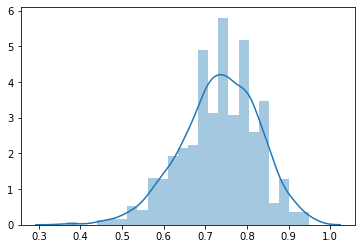

In [263]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'90% CI is {np.quantile(rand_score, [0.05, 0.95])}')
sns.distplot(rand_score)

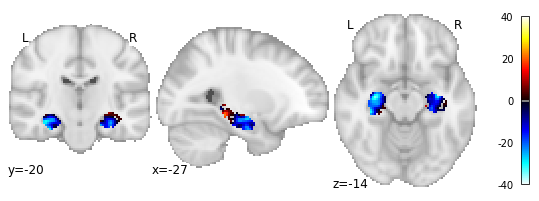

In [267]:
img_ket = masker.inverse_transform(np.mean(ketArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_ket, threshold=1, display_mode='ortho', draw_cross=False, 
                          cut_coords=[-27,-20,-14], colorbar=True, vmax=40)

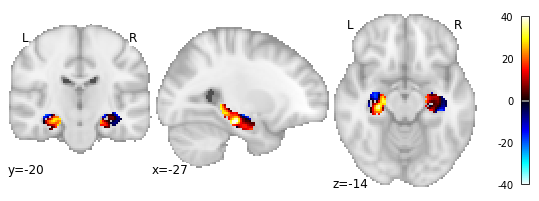

In [268]:
img_mid = masker.inverse_transform(np.mean(midArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_mid, threshold=1, display_mode='ortho', draw_cross=False, 
                          cut_coords=[-27,-20,-14], colorbar=True,  vmax=40)

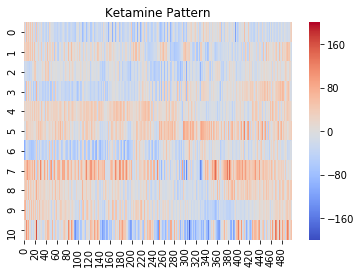

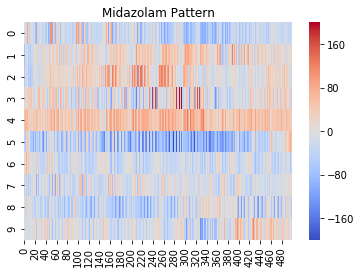

In [274]:
#plt.figure(figsize=(30,10))
sns.heatmap(ketArr_reshape, cmap="coolwarm", vmax=200, vmin = -200)
plt.title("Ketamine Pattern")
plt.show()
#plt.figure(figsize=(30,10))
sns.heatmap(midArr_reshape, cmap="coolwarm", vmax=200, vmin = -200)
plt.title("Midazolam Pattern")
plt.show()


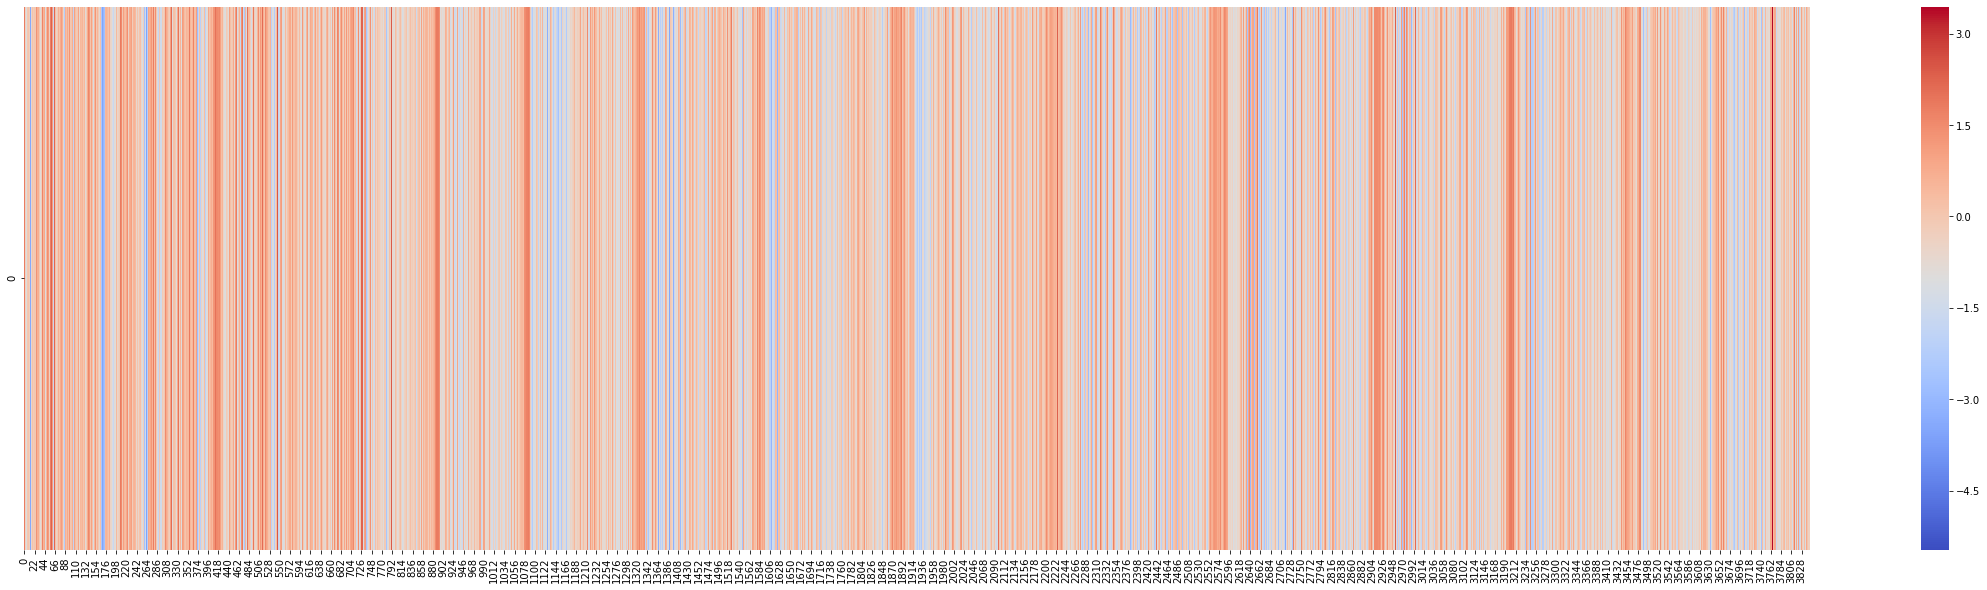

In [479]:
tTestArr = scipy.stats.ttest_ind(ketArr_reshape, midArr_reshape,  equal_var=True, nan_policy='propagate')
plt.figure(figsize=(40,10))
sns.heatmap([tTestArr[0]], cmap="coolwarm")

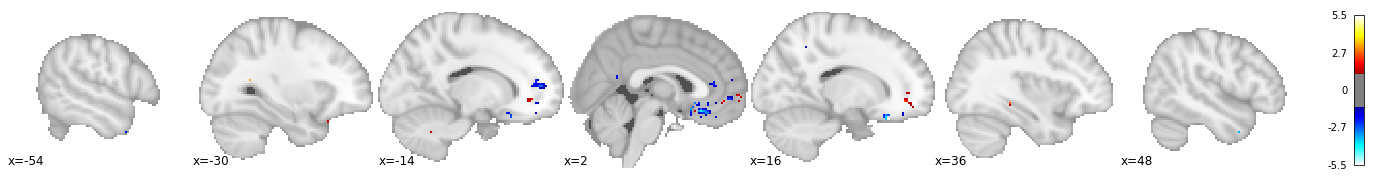

In [480]:
# turn back to brain?
img = masker.inverse_transform(tTestArr[0]) # turn the t array back to brain image
nilearn.plotting.plot_stat_map(img, display_mode='x', threshold=1.3) # stat plot everything beyond threshold
#nilearn.plotting.plot_img(img, threshold=.001, display_mode='z') # just plot the ROI image
# one interactive plot - so we can play with locations
#view = plotting.view_img(img, threshold=2, title="Ketamine - Midazolam Hippocampus")
#view


## Striatum

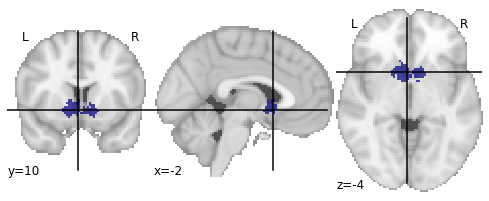

In [270]:
mask_file = '/media/Data/work/KPE_ROI/binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz'
mask_file = nilearn.image.math_img("a>=0.001", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=4, standardize=False, detrend=False, verbose=5)

In [271]:
ketamine = []
for func in ket_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    ketamine.append(beta)

midazolam = []
for func in mid_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    midazolam.append(beta)

ketArr = np.array(ketamine)
ketArr_reshape= np.array(ketArr).reshape(ketArr.shape[0], ketArr.shape[2])
ketArr_reshape.shape


midArr = np.array(midazolam)
midArr_reshape= np.array(midArr).reshape(midArr.shape[0], midArr.shape[2])
midArr_reshape.shape


## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * ketArr.shape[0]
label2 = [0] * midArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

X = np.concatenate([ketArr, midArr])
X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_008/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1223/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mas

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1263/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/work/fsl_analysis_ses2/modelfit/_subject_id_1351/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz
[NiftiMas

(21, 500)

In [272]:
n_iter = 1000
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

 Running 362 iteration
 Running 363 iteration
 Running 364 iteration
 Running 365 iteration
 Running 366 iteration
 Running 367 iteration
 Running 368 iteration
 Running 369 iteration
 Running 370 iteration
 Running 371 iteration
 Running 372 iteration
 Running 373 iteration
 Running 374 iteration
 Running 375 iteration
 Running 376 iteration
 Running 377 iteration
 Running 378 iteration
 Running 379 iteration
 Running 380 iteration
 Running 381 iteration
 Running 382 iteration
 Running 383 iteration
 Running 384 iteration
 Running 385 iteration
 Running 386 iteration
 Running 387 iteration
 Running 388 iteration
 Running 389 iteration
 Running 390 iteration
 Running 391 iteration
 Running 392 iteration
 Running 393 iteration
 Running 394 iteration
 Running 395 iteration
 Running 396 iteration
 Running 397 iteration
 Running 398 iteration
 Running 399 iteration
 Running 400 iteration
 Running 401 iteration
 Running 402 iteration
 Running 403 iteration
 Running 404 iteration
 Running 40

 Running 719 iteration
 Running 720 iteration
 Running 721 iteration
 Running 722 iteration
 Running 723 iteration
 Running 724 iteration
 Running 725 iteration
 Running 726 iteration
 Running 727 iteration
 Running 728 iteration
 Running 729 iteration
 Running 730 iteration
 Running 731 iteration
 Running 732 iteration
 Running 733 iteration
 Running 734 iteration
 Running 735 iteration
 Running 736 iteration
 Running 737 iteration
 Running 738 iteration
 Running 739 iteration
 Running 740 iteration
 Running 741 iteration
 Running 742 iteration
 Running 743 iteration
 Running 744 iteration
 Running 745 iteration
 Running 746 iteration
 Running 747 iteration
 Running 748 iteration
 Running 749 iteration
 Running 750 iteration
 Running 751 iteration
 Running 752 iteration
 Running 753 iteration
 Running 754 iteration
 Running 755 iteration
 Running 756 iteration
 Running 757 iteration
 Running 758 iteration
 Running 759 iteration
 Running 760 iteration
 Running 761 iteration
 Running 76

Area under curve: 0.77 (+/- 0.19)
90% CI is [0.6 0.9]


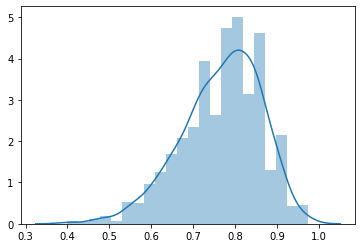

In [273]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'90% CI is {np.quantile(rand_score, [0.05, 0.95])}')
sns.distplot(rand_score)

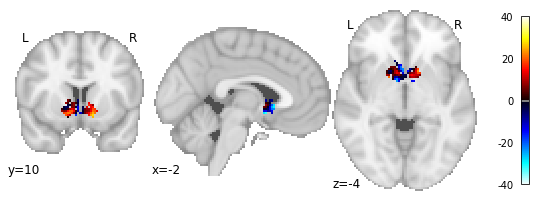

In [275]:
img_ket = masker.inverse_transform(np.mean(ketArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_ket, threshold=1, display_mode='ortho', draw_cross=False, 
                          cut_coords=[-2,10,-4], colorbar=True, vmax=40)

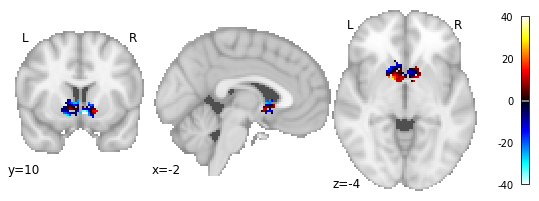

In [276]:
img_mid= masker.inverse_transform(np.mean(midArr_reshape, axis=0))
nilearn.plotting.plot_stat_map(img_mid, threshold=1, display_mode='ortho', draw_cross=False, 
                          cut_coords=[-2,10,-4], colorbar=True, vmax=40)

## We need to run permutation test to see if the values we get are actually different than something we might randomly get

In [ ]:
# organize labels of group and vector for each

# start shuffle the group and see how many times we get such a difference

## Using the t-tests and FDR to see what survives

In [481]:
# First simple t test like we did befor
tTestArr = scipy.stats.ttest_ind(ketArr_reshape, midArr_reshape,  equal_var=True, nan_policy='propagate')
tTestArr

Ttest_indResult(statistic=array([ 0.07429292,  1.7787675 , -1.0281352 , ...,  0.53116673,
       -0.3836815 , -0.34552237], dtype=float32), pvalue=array([0.94155392, 0.09128311, 0.316798  , ..., 0.6014582 , 0.70547421,
       0.73349779]))

In [482]:
# use fdr correction for multiple comparisons
from statsmodels.stats import multitest
# we need to reshape the test p-values array to create 1D array
alpha = .05 # set p value
fdr_mat = multitest.multipletests(tTestArr[1], alpha=alpha, method='fdr_bh', is_sorted=False, returnsorted=False)
print(f'Number of significant voxels is {np.sum(fdr_mat[0])}')

Number of significant voxels is 0


In [439]:
# threshold the t array 
corr_mat_thrFDR = np.array(tTestArr[0])
corr_mat_thrFDR[fdr_mat[0]==False] = 0
# now we can turn it back to brain image and plot 
fdr_img = masker.inverse_transform(corr_mat_thrFDR)
  

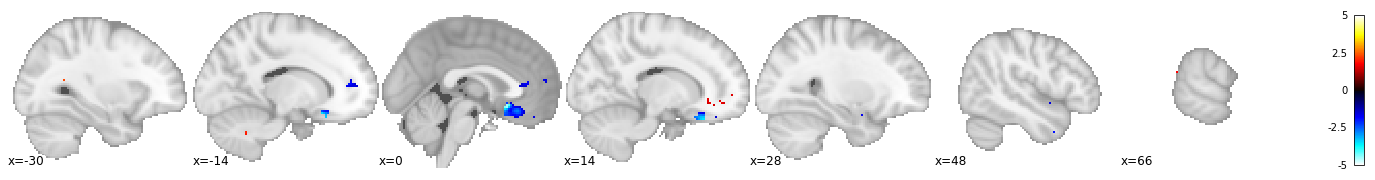

In [414]:
plotting.plot_stat_map(fdr_img, display_mode='x')